<a href="https://colab.research.google.com/github/Dimbinantenaina/Convnet_cat-vs-dog/blob/master/Dimby_VAE_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from matplotlib import pyplot as plt
import torch.nn.functional as F

In [2]:
torch.cuda.is_available()

True

In [0]:
# Convert vector to image
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

In [0]:
bs = 64 #batch size

transform = transforms.Compose([transforms.ToTensor()])

traindataset = FashionMNIST('./data', download=True, train=True, transform=transform)
testdataset = FashionMNIST('./data', download=True, train=False, transform=transform)

# Loaders
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=bs, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=bs, shuffle=False, num_workers=4)

In [0]:
# Displaying routine
def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [0]:
# These 2 functions compute the output sizes for conv2d and convtranspose2d
def out_size(hin, win, ks, p=0, d=1, st=1):
  """
  compute the output size of conv2d

  hin: input hight(int)
  win: input width(int)
  p : padding(int) 
  d: dilatation (int) 
  ks: kernelsize
  st : stride
  """
  hout = int((hin + 2*p - d*(ks-1) -1)//st +1)
  wout = int((hin + 2*p - d*(ks-1) -1)//st +1)
  return hout, wout

def out_size_t(hin,win, ks,p=0, d=1, st=1, groups=1, op = 0):
  """
  compute the output size of ConvTranspose2d
 Defaults: stride=1, padding=0, output_padding=0,
           groups=1, bias=True, dilation=1, padding_mode='zeros'
  hin: input hight(int)
  win: input width(int)
  p : padding(int) 
  d: dilatation (int) 
  ks: kernelsize (int)
  st : stride (int)
  op : output_padding(int)
  """
  hout = int((hin-1)*st - 2*p + d*(ks-1) + op +1)
  wout = int((win-1)*st - 2*p + d*(ks-1) + op +1)
  return hout, wout

In [0]:
# The model
z_size = 20
initial_size = 28
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # encoder infrastructure
        self.enc1 = nn.Conv2d(in_channels= 1, out_channels= 16 , kernel_size= 3)
        self.enc1_outsize = out_size(initial_size,initial_size,3)

        self.enc2 = nn.Conv2d(in_channels= 16, out_channels= 16 , kernel_size= 3)
        self.enc2_outsize = out_size(self.enc1_outsize[0], self.enc1_outsize[1],3)

        self.enc3 = nn.Conv2d(in_channels= 16, out_channels= 8 , kernel_size= 3)
        self.enc3_outsize = out_size(self.enc2_outsize[0], self.enc2_outsize[1], 3)

        # encoder
        self.encoder = nn.Sequential(self.enc1, nn.ReLU(), self.enc2,
                                      self.enc3)
        
        # mu, sigma, and z
        encoded_dim = 8*self.enc3_outsize[0]*self.enc3_outsize[1]
        self.mu = nn.Linear(encoded_dim, z_size)
        self.var = nn.Linear(encoded_dim, z_size)
        self.z = nn.Linear(z_size, encoded_dim)
        
        # Decoder infrastructure
        self.dec1 = nn.ConvTranspose2d(in_channels= 8, out_channels= 16 , kernel_size= 3)
        self.dec1_outsize = out_size_t(self.enc2_outsize[0], self.enc2_outsize[1],3)

        self.dec2 = nn.ConvTranspose2d(in_channels = 16, out_channels = 16 , kernel_size= 3)
        self.dec2_outsize = out_size_t(self.dec1_outsize[0], self.dec1_outsize[1],3)

        self.dec3 = nn.ConvTranspose2d(in_channels = 16, out_channels = 1 , kernel_size= 3)
        self.dec3_outsize = out_size_t(self.dec2_outsize[0], self.dec2_outsize[1],3)

        # Decoder
        self.decoder = nn.Sequential(self.dec1, nn.ReLU() ,self.dec2, 
                                      self.dec3)

    #reparametrization 
    def reparam(self, mu, logsig):
        std = torch.exp(.3*logsig)
        eps = torch.randn_like(std)
        return mu + std*eps


    def forward(self, x):
        n = x.size() # saves the original shape
        x = self.encoder(x)# encoding
        d = x.size() #saves the shape after encoding
        x = x.flatten(start_dim=1)
        m = self.mu(x)
        s = self.var(x)
        x = self.reparam(m, s)#reparametrization
        x = self.z(x) # recovering the original dimension
        x = x.view(d) # recovering the shape after encoding
        x = self.decoder(x) # decoding
        x = torch.sigmoid(x).view(n) # brings the pixels to (0,1) and recover the original shape
        return x, m, s

In [0]:
# our loss function
def loss_function(rec_x, x, mu, sigma, beta = 3):
    BCE = F.binary_cross_entropy(rec_x, x, reduction = 'sum')
    KLD = -torch.mean(1+sigma-mu.pow(2)-sigma.exp())
    return BCE + beta*KLD


In [0]:
model = VAE()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

use_cuda = True # False to disable GPU
if use_cuda and torch.cuda.is_available():
    model.cuda()

epoch [1/10], loss:6440.6396
epoch [2/10], loss:7004.6040
epoch [3/10], loss:6661.8286
epoch [4/10], loss:6642.5352
epoch [5/10], loss:6828.1196
epoch [6/10], loss:6745.8706
epoch [7/10], loss:6794.6768
epoch [8/10], loss:7324.4014
epoch [9/10], loss:6498.8232
epoch [10/10], loss:6761.0439


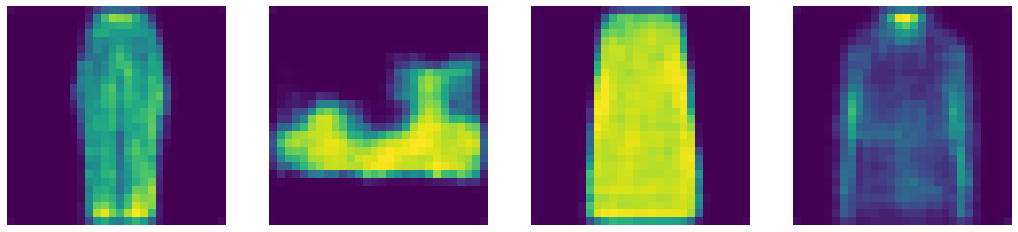

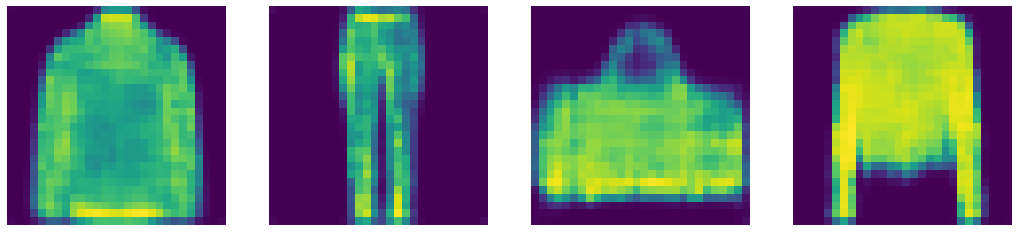

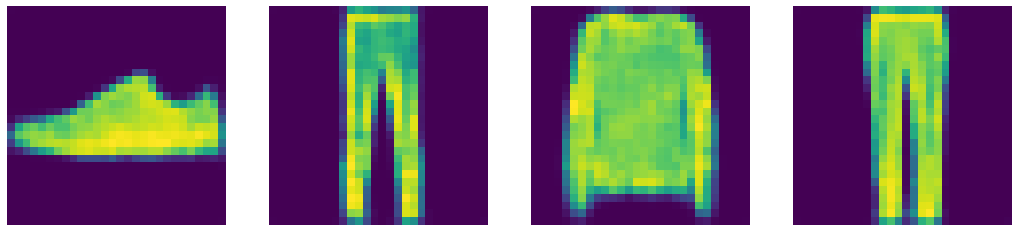

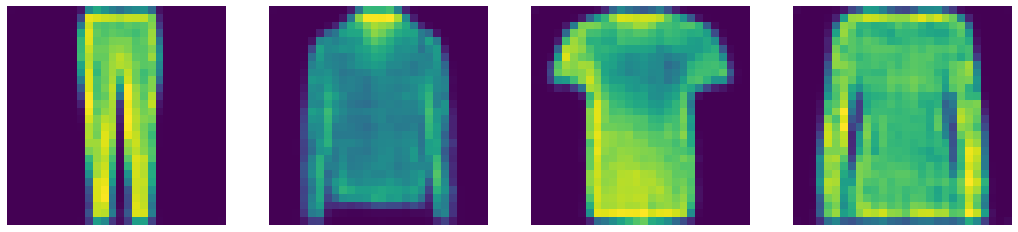

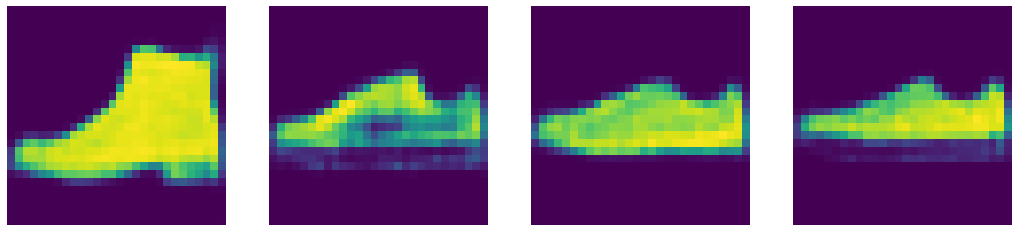

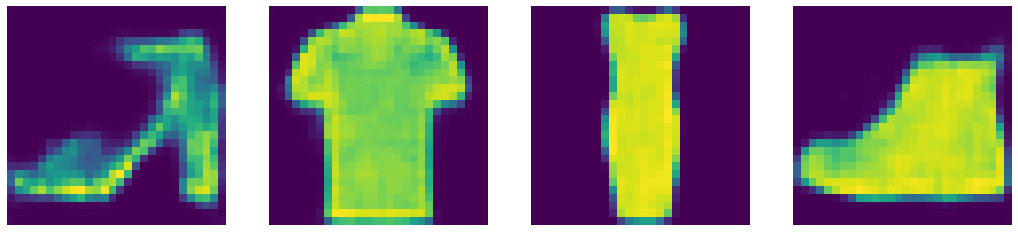

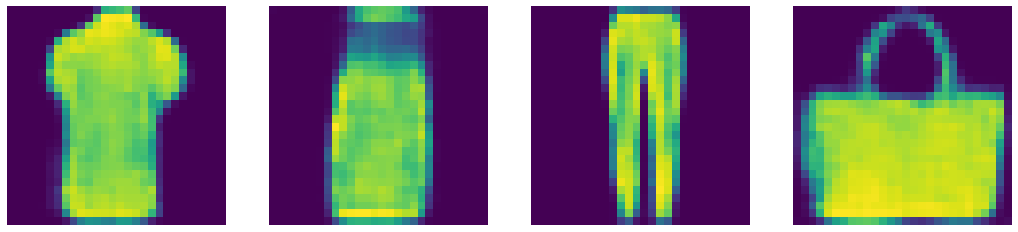

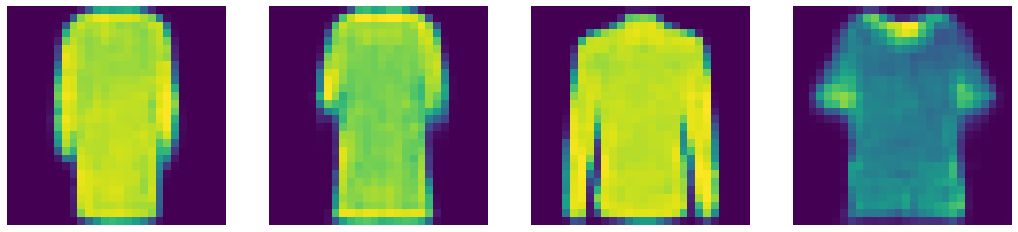

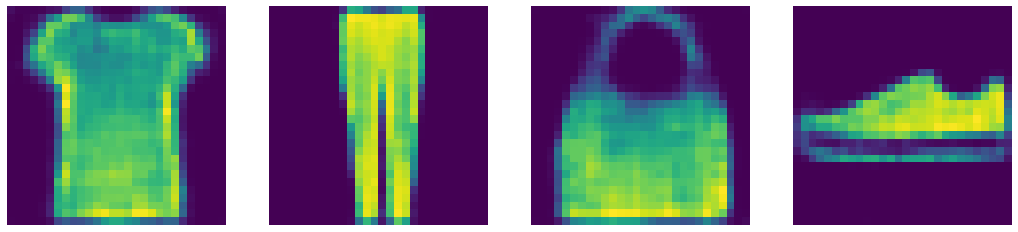

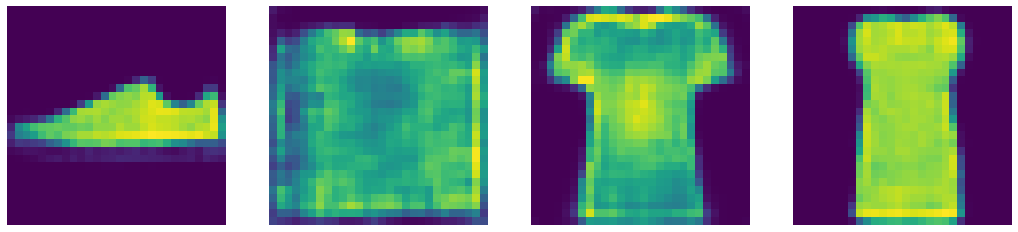

In [33]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x, _ in trainloader:
        if use_cuda and torch.cuda.is_available() :
            x = x.cuda()
#     forward
        x_hat, mu, logvar = model(x)
        loss = loss_function(x_hat, x, mu, logvar)
        train_loss += loss.item()
  # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, x_hat)

In [0]:
from torch.autograd import Variable
plt.style.use('default')
%matplotlib inline 

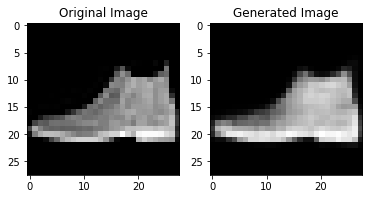

In [35]:
test_images, labels = next(iter(testloader))
test_output = model(test_images.cuda())[0]
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

fig = plt.figure()
plot = fig.add_subplot(1, 2, 1)
plot.set_title('Original Image')
imgplot = plt.imshow(inp[0].cpu(), cmap='gray')

plot = fig.add_subplot(1, 2, 2)
plot.set_title('Generated Image')
imgplot = plt.imshow(out[0].cpu().detach(), cmap='gray')
plt.show()

# Exercises

Your exercise should you choose to accept, is to 

1. change the model class to use Convolution Layers and re-run with the same training code in cells below.
2. Edit the code above for denoising autoencoder? (bonus point if your code it)
3. Briefly describe the performance of using the fully connected auto-encoder to the CNN_Autoencoder

Deadline: Today: 2:pm

3. Using 2 convolutional layers for both the encoder and the decoder, the performance of the CNN auto-encoder is almost four times the performance of the fully connected auto-encoder.